# 1.Extract

Crawl link car detail use selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd 
import numpy as np
import requests

from bs4 import BeautifulSoup 


service = Service(executable_path="chromedriver.exe")
driver = webdriver.Chrome(service=service)

url = "https://www.carmudi.vn/xe-o-to/"
driver.get(url)
wait = WebDriverWait(driver, 10)  

all_links = []

for page in range(1, 175): 
    try:
                 
        car_titles = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "h3.text-lg.h-12.line-clamp-2.leading-6.mt-4.mb-3 a")))

        all_links.extend([{"link": car.get_attribute("href")} for car in car_titles])
                       
        print(f" Lấy xong trang {page}, có {len(car_titles)} xe") 

        try: 
            next_btn = driver.find_element(By.XPATH, "//button[@aria-label='Go to next page']")
            driver.execute_script("arguments[0].click();", next_btn) 
            wait.until(EC.staleness_of(car_titles[0]))
        except:
            print("End Page")
            break
    except:
        print(f"Không tìm thấy trang {page}")
        break

df = pd.DataFrame(all_links)
df.to_csv("link_cars_detail.csv", encoding="utf-8-sig")
print(df)

driver.quit()


Crawl detail car

In [ ]:
import re

df_links = pd.read_csv("link_cars_detail.csv")

headers = {
      'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/140.0.0.0 Mobile Safari/537.36',
      "Accept": "application/json, text/plain, */*",
}

session = requests.Session()
session.headers.update(headers)
    
cars = []

for link in df_links["link"]:  # demo 30 xe trước
    try:
        r = session.get(link, timeout=5)
        if r.status_code != 200:
            print("❌ Lỗi request:", link)
            continue

        soup = BeautifulSoup(r.text, "html.parser")

        # --- id ---
        car_id = re.search(r"-(\d+)/?$", link)
        car_id = car_id.group(1) if car_id else np.nan

        # --- name ---
        name = soup.select_one("h1.text-lg.md\\:text-xl.line-clamp-2.leading-7.font-semibold")
        name = name.get_text(strip=True) if name else np.nan

        # --- price ---
        price = soup.select_one("h3.text-lg.md\\:text-xl.text-red-500.font-bold")
        price = price.get_text(strip=True) if price else np.nan

        # --- created (ngày đăng) ---
        created_tag = soup.select_one("div.text-right.w-40.text-xs.pt-2 i")
        created = created_tag.get_text(strip=True) if created_tag else np.nan
        
        #hang sx
        manufacturer = np.nan
        manufacturer_block = soup.find("span", string=re.compile("Hãng xe", re.I))
        if manufacturer_block: 
            manufacturer = manufacturer_block.find_next("span", class_="font-semibold")
            manufacturer = manufacturer.get_text(strip=True) if manufacturer else np.nan


        #nam sx
        manufacture_year = np.nan
        manufacture_year_block = soup.find("p", string=re.compile("Năm sản xuất", re.I))
        if manufacture_year_block:
            manufacture_year = manufacture_year_block.find_next("p", class_="float-right font-semibold")
            manufacture_year = manufacture_year.get_text(strip=True) if manufacture_year else np.nan
        #year in name
        if pd.isna(manufacture_year) and name:
            match = re.search(r"\b(19|20)\d{2}\b", name)
            manufacture_year = match.group(0) if match else np.nan

        #city
        city = soup.select_one("p.text-right.float-right.cursor-pointer.font-semibold.md\\:max-w-xs.max-w-\\[50\\%\\]")
        city = city.get_text(strip=True) if city else np.nan
        
        #kieu dang
        body_type = np.nan
        body_type_block = soup.find("span", string=re.compile("Kiểu dáng", re.I))
        if body_type_block:
            body_type = body_type_block.find_next("span", class_="font-semibold")
            body_type = body_type.get_text(strip=True) if body_type else np.nan
        

        #so km/ tinh trang
        mileage = np.nan
        mileage_block = soup.find("p", string=re.compile("Số KM", re.I))
        if mileage_block:
            mileage = mileage_block.find_next("p", class_="float-right font-semibold")
            mileage = mileage.get_text(strip=True) if mileage else np.nan
        

        #Hop so
        transmission = np.nan
        transmission_block = soup.find("p", string=re.compile("Hộp số", re.I))
        if transmission_block:
            transmission = transmission_block.find_next("p", class_="float-right font-semibold")
            transmission = transmission.get_text(strip=True) if transmission else np.nan

        #nhien lieu
        fuel = np.nan
        fuel_block = soup.find("p", string=re.compile("Nhiên liệu", re.I))
        if fuel_block:
            fuel = fuel_block.find_next("p", class_="float-right font-semibold")
            fuel = fuel.get_text(strip=True) if fuel else np.nan
        # --- các thông số kỹ thuật ---
        info_blocks = soup.select("div.flex.justify-between")
        specs = {}
        for block in info_blocks:
            spans = block.select("span")
            if len(spans) == 2:
                label = spans[0].get_text(strip=True)
                value = spans[1].get_text(strip=True)
                specs[label] = value

        car_data = {
            "id": car_id,
            "name": name,
            "price": price,
            "manufacturer": manufacturer,
            "created": created,
            "manufacture_year": manufacture_year,
            "origin": np.nan, #k có trường origin
            "city": city,
            "body_type": body_type,
            "mileage": mileage,
            "transmission": transmission,
            "condition": mileage,
            "fuel": fuel
        }

        cars.append(car_data)

        if len(cars) % 10 == 0:
            print(f"crawled ${len(cars)}")
    except Exception as e:
        print("❌ Lỗi:", link, e)
    
df = pd.DataFrame(cars)
df.to_csv("crawl_cars_1.csv", index=False, encoding="utf-8-sig")


# Transform 

function proceed origin

In [22]:
import re

brand_origin_map = {
    # Lắp ráp trong nước
    'vinfast': 'Lắp ráp trong nước',
    'kia': 'Lắp ráp trong nước',
    'mazda': 'Lắp ráp trong nước',
    'peugeot': 'Lắp ráp trong nước',
    'hyundai': 'Lắp ráp trong nước',
    'toyota': 'Lắp ráp trong nước',
    'honda': 'Lắp ráp trong nước',
    'ford': 'Lắp ráp trong nước',
    'mitsubishi': 'Lắp ráp trong nước',
    'suzuki': 'Lắp ráp trong nước',
    'isuzu': 'Lắp ráp trong nước',
    'nissan': 'Lắp ráp trong nước',
    'thaco': 'Lắp ráp trong nước',

    # Nhập khẩu hoàn toàn
    'bmw': 'Nhập khẩu',
    'mercedes': 'Nhập khẩu',
    'audi': 'Nhập khẩu',
    'lexus': 'Nhập khẩu',
    'porsche': 'Nhập khẩu',
    'volvo': 'Nhập khẩu',
    'land rover': 'Nhập khẩu',
    'jaguar': 'Nhập khẩu',
    'mg': 'Nhập khẩu',
    'byd': 'Nhập khẩu',
    'chery': 'Nhập khẩu',
    'geely': 'Nhập khẩu',
    'tesla': 'Nhập khẩu',
    'jeep': 'Nhập khẩu',
}
def infer_origin(name): 
    if not name:  
        return "Không xác định"
    name_lower = name.lower().replace("-", " ")
    for brand, origin in brand_origin_map.items():
        #Bảo đảm rằng các ký tự đặc biệt trong tên thương hiệu (như ., +, *, ?, v.v.) không bị hiểu là ký tự đặc biệt trong regex.
        #\b trong regex là word boundary, tức là ranh giới từ.
        # Nó đảm bảo rằng regex chỉ match từ nguyên vẹn, không phải là một phần của từ khác.
        if re.search(r'\b' + re.escape(brand) + r'\b', name_lower):
            return origin
    return "Không xác định"

transform main

In [ ]:
import pandas as pd
import re

df = pd.read_csv("crawl_cars_1.csv")


# Chuan hoa price
def convert_price(x):
    if pd.isna(x): return None
    s = str(x).lower().replace(",", ".").strip()
    total = 0.0
    matches = re.findall(r"(\d[\d\.]*)\s*(tỷ|triệu)", s)
    if not matches:
        try: return float(s)
        except: return None
    for amt, unit in matches:
        try: total += float(amt) * (1000 if unit=="tỷ" else 1)
        except: continue
    return total

df["price"] = df["price"].apply(convert_price)

print(pd.DataFrame(df["price"][:50]))

#Chuan hoa created -> Datetime
df["created"] = df["created"].str.split(':').str[1]
df["created"] = pd.to_datetime(df["created"])

print(pd.DataFrame(df["created"][:50]))

#Chuan hoa manufacture_year (nam sx)
df["manufacture_year"] = df["manufacture_year"].astype(int)


#Chuan hoa city
provinces = [
    "Hà Nội","Hồ Chí Minh","An Giang","Bà Rịa – Vũng Tàu","Bắc Giang","Bắc Kạn","Bạc Liêu","Bắc Ninh",
    "Bến Tre","Bình Định","Bình Dương","Bình Phước","Bình Thuận","Cà Mau","Cần Thơ","Cao Bằng","Đà Nẵng",
    "Đắk Lắk","Đắk Nông","Điện Biên","Đồng Nai","Đồng Tháp","Gia Lai","Hà Giang","Hà Nam","Hà Tĩnh","Hải Dương",
    "Hải Phòng","Hậu Giang","Hòa Bình","Hưng Yên","Khánh Hòa","Kiên Giang","Kon Tum","Lai Châu","Lâm Đồng",
    "Lạng Sơn","Lào Cai","Long An","Nam Định","Nghệ An","Ninh Bình","Ninh Thuận","Phú Thọ","Phú Yên",
    "Quảng Bình","Quảng Nam","Quảng Ngãi","Quảng Ninh","Quảng Trị","Sóc Trăng","Sơn La","Tây Ninh","Thái Bình",
    "Thái Nguyên","Thanh Hóa","Thừa Thiên – Huế","Tiền Giang","Trà Vinh","Tuyên Quang","Vĩnh Long","Vĩnh Phúc",
    "Yên Bái"
]

df["city"] = df["city"].apply(lambda x: next((p for p in provinces if p in x), None))

print(pd.DataFrame(df["city"][:50]))

#Chuan hoa mileage (so km da di)
def convert_mileage(x):
    if pd.isna(x):
        return None
    x = str(x).lower().strip()
    if "xe mới" in x:
        return '0'
    return str(x.replace("km", "").replace(",", "").strip())

df["mileage"] = df["mileage"].apply(convert_mileage)
df["mileage"] = df["mileage"].astype(float)

print(pd.DataFrame(df["mileage"][:50]))

#Chuan hoa condition
df["condition"] = df["mileage"].apply(lambda x: "Xe mới" if x == 0 else "Đã qua sử dụng")
print(pd.DataFrame(df["condition"][:50]))

#Chuan hoa origin tu manufacturer
df["origin"] = df["manufacturer"].apply(infer_origin)
print(pd.DataFrame(df["origin"][:50]))

#Xu ly gia tri NaN
nan_counts = df.isna().sum()
print(nan_counts)

df["city"] = df["city"].fillna("Không xác định")


df.to_csv("crawl_cars_1_cleaned.csv", index=False,  encoding="utf-8-sig")


     price
0    420.0
1    245.0
2   3499.0
3    330.0
4    760.0
5    465.0
6    125.0
7   1140.0
8    600.0
9    680.0
10   280.0
11   540.0
12   300.0
13   115.0
14   949.0
15   350.0
16   190.0
17   919.0
18   919.0
19   899.0
20   899.0
21   899.0
22  1759.0
23   919.0
24   450.0
25   500.0
26   420.0
27   135.0
28   805.0
29   550.0
30   530.0
31   355.0
32   590.0
33  1150.0
34   265.0
35   550.0
36   530.0
37   355.0
38   590.0
39  1150.0
40   265.0
41   370.0
42   250.0
43   490.0
44   125.0
45   530.0
46   159.0
47  1299.0
48   780.0
49   800.0
      created
0  2025-09-08
1  2025-08-12
2  2025-10-04
3  2025-10-04
4  2025-10-04
5  2025-10-04
6  2025-10-04
7  2025-10-04
8  2025-10-04
9  2025-10-04
10 2025-10-04
11 2025-10-04
12 2025-10-04
13 2025-10-04
14 2025-10-03
15 2025-10-03
16 2025-10-03
17 2025-10-03
18 2025-10-03
19 2025-10-03
20 2025-10-03
21 2025-10-03
22 2025-10-03
23 2025-10-03
24 2025-10-03
25 2025-10-03
26 2025-10-03
27 2025-10-03
28 2025-10-03
29 2025-10-03
30 20

check data

In [29]:
#Kiem tra du lieu
nan_counts = df.isna().sum()
print(nan_counts)
print(df.dtypes)

name                0
price               0
manufacturer        0
created             0
manufacture_year    0
origin              0
city                0
body_type           0
mileage             0
transmission        0
condition           0
fuel                0
dtype: int64
name                        object
price                      float64
manufacturer                object
created             datetime64[ns]
manufacture_year             int32
origin                      object
city                        object
body_type                   object
mileage                    float64
transmission                object
condition                   object
fuel                        object
dtype: object


Chuẩn hóa dữ liệu bằng Min-Max Scaling

In [10]:
import pandas as pd

df = pd.read_csv('crawl_cars_1_cleaned.csv')

min_price = df["price"].min()
max_price = df["price"].max()

df["price_minmax"] = (df["price"] - min_price) / (max_price - min_price)
print(df[["price", "price_minmax"]].head(50))
print(f"min_price: {min_price}", f"max_price: {max_price}")

min_mileage = df["mileage"].min()
max_mileage = df["mileage"].max()

df["mileage_minmax"] = (df["mileage"] - min_mileage) / (max_mileage - min_mileage)
print(df[["mileage", "mileage_minmax"]].head(50))
print(f"min_mileage: {min_mileage}", f"max_mileage: {max_mileage}")

     price  price_minmax
0    420.0      0.031683
1    245.0      0.014356
2   3499.0      0.336535
3    330.0      0.022772
4    760.0      0.065347
5    465.0      0.036139
6    125.0      0.002475
7   1140.0      0.102970
8    600.0      0.049505
9    680.0      0.057426
10   280.0      0.017822
11   540.0      0.043564
12   300.0      0.019802
13   115.0      0.001485
14   949.0      0.084059
15   350.0      0.024752
16   190.0      0.008911
17   919.0      0.081089
18   919.0      0.081089
19   899.0      0.079109
20   899.0      0.079109
21   899.0      0.079109
22  1759.0      0.164257
23   919.0      0.081089
24   450.0      0.034653
25   500.0      0.039604
26   420.0      0.031683
27   135.0      0.003465
28   805.0      0.069802
29   550.0      0.044554
30   530.0      0.042574
31   355.0      0.025248
32   590.0      0.048515
33  1150.0      0.103960
34   265.0      0.016337
35   550.0      0.044554
36   530.0      0.042574
37   355.0      0.025248
38   590.0      0.048515


Chuẩn hóa dữ liệu bằng Z-score

In [ ]:
import pandas as pd

df = pd.read_csv('crawl_cars_1_cleaned.csv')

mean_price = df["price"].mean()
std_price = df["price"].std()
df["price_zscore"] = (df["price"] - mean_price) / std_price

print(df[["price", "price_zscore"]].head(50))
print(f"mean_price: {mean_price}",f"std_price: {std_price}")

mean_mileage = df["mileage"].mean()
std_mileage = df["mileage"].std()
df["mileage_zscore"] = (df["mileage"] - mean_mileage) /std_mileage
print(df[["mileage", "mileage_zscore"]].head(50))
print(f"mean_mileage: {mean_mileage}", f"std_mileage: {std_mileage}")

df.to_csv("crawl_cars_1_cleaned_zscore.csv", index=False,  encoding="utf-8-sig")


     price  price_zscore
0    420.0     -0.291019
1    245.0     -0.489885
2   3499.0      3.207893
3    330.0     -0.393293
4    760.0      0.095350
5    465.0     -0.239882
6    125.0     -0.626251
7   1140.0      0.527174
8    600.0     -0.086471
9    680.0      0.004440
10   280.0     -0.450112
11   540.0     -0.154654
12   300.0     -0.427385
13   115.0     -0.637615
14   949.0      0.310126
15   350.0     -0.370566
16   190.0     -0.552386
17   919.0      0.276034
18   919.0      0.276034
19   899.0      0.253307
20   899.0      0.253307
21   899.0      0.253307
22  1759.0      1.230593
23   919.0      0.276034
24   450.0     -0.256928
25   500.0     -0.200109
26   420.0     -0.291019
27   135.0     -0.614887
28   805.0      0.146487
29   550.0     -0.143290
30   530.0     -0.166017
31   355.0     -0.364884
32   590.0     -0.097835
33  1150.0      0.538538
34   265.0     -0.467158
35   550.0     -0.143290
36   530.0     -0.166017
37   355.0     -0.364884
38   590.0     -0.097835


Chuẩn hóa bằng biến đổi log (cột mileage)

In [14]:
import numpy as np

df['mileage_log'] = np.log1p(df['mileage'])
print(df[['mileage', 'mileage_log']].head(50))


     mileage  mileage_log
0        0.0     0.000000
1   120000.0    11.695255
2        0.0     0.000000
3        0.0     0.000000
4        0.0     0.000000
5        0.0     0.000000
6        0.0     0.000000
7        0.0     0.000000
8        0.0     0.000000
9        0.0     0.000000
10       0.0     0.000000
11       0.0     0.000000
12       0.0     0.000000
13       0.0     0.000000
14       0.0     0.000000
15       0.0     0.000000
16       0.0     0.000000
17       0.0     0.000000
18       0.0     0.000000
19       0.0     0.000000
20       0.0     0.000000
21       0.0     0.000000
22       0.0     0.000000
23       0.0     0.000000
24       0.0     0.000000
25       0.0     0.000000
26       0.0     0.000000
27       0.0     0.000000
28       0.0     0.000000
29       0.0     0.000000
30       0.0     0.000000
31       0.0     0.000000
32       0.0     0.000000
33       0.0     0.000000
34       0.0     0.000000
35       0.0     0.000000
36       0.0     0.000000
37       0.0

# Visualization


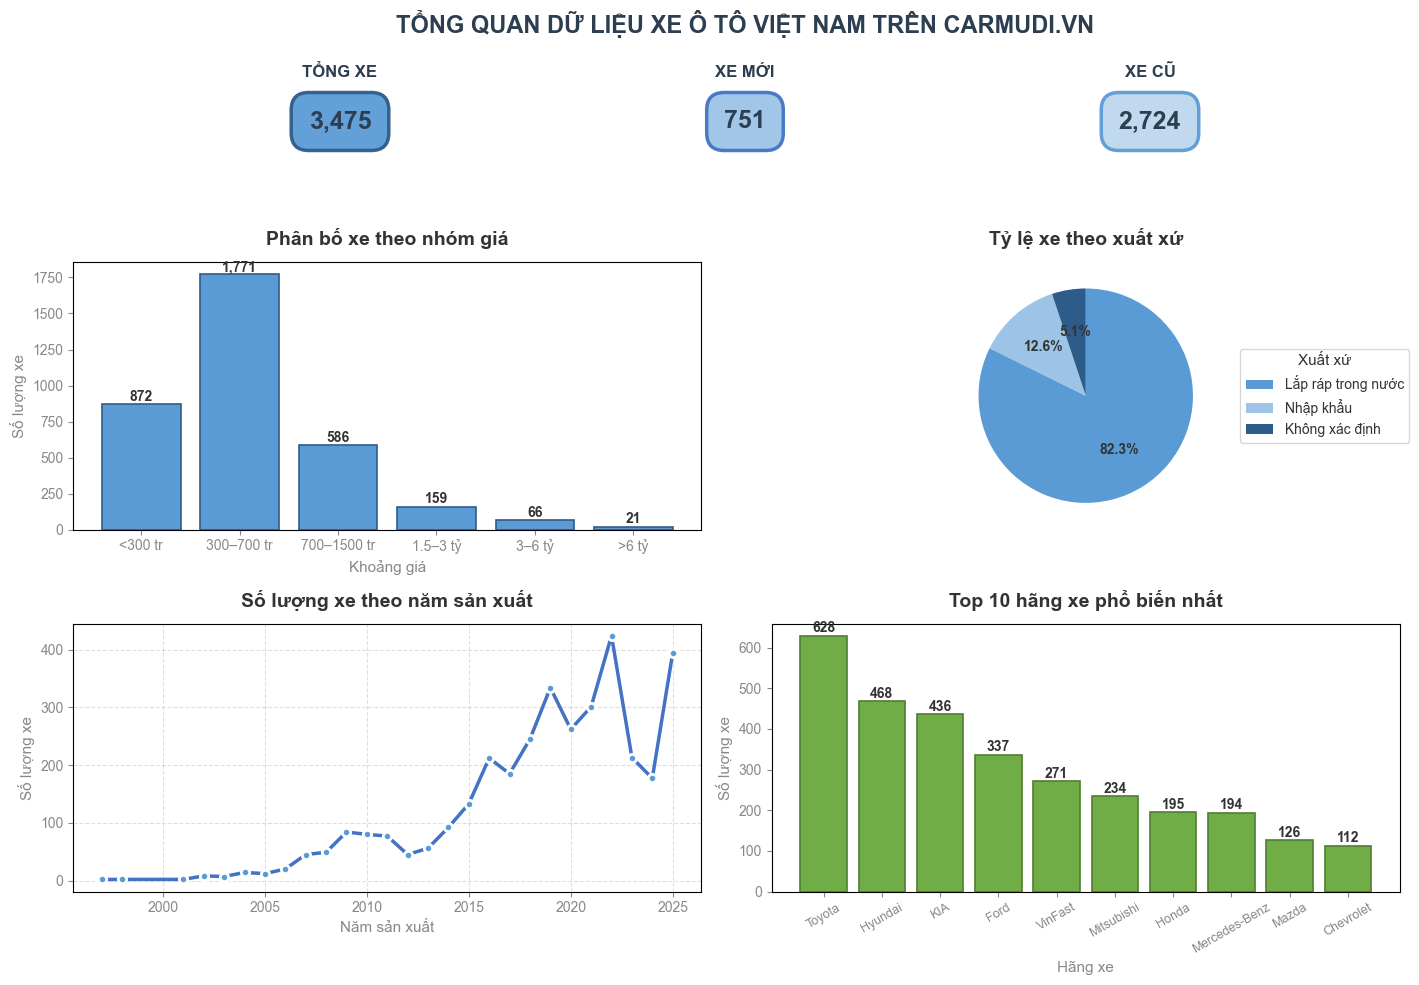

In [68]:
import pandas as pd 
import matplotlib.pyplot as plt

# --- Chuẩn bị dữ liệu (ví dụ) ---
bins = [0, 300, 700, 1500, 3000, 6000, 15000]
labels = ['<300 tr', '300–700 tr', '700–1500 tr', '1.5–3 tỷ', '3–6 tỷ', '>6 tỷ']
df['price_group'] = pd.cut(df['price'], bins=bins, labels=labels)

counts_price = df['price_group'].value_counts().sort_index()
top_brands = df['manufacturer'].value_counts().head(10)
origin_counts = df['origin'].value_counts()
year_counts = df['manufacture_year'].value_counts().sort_index()
total_cars = len(df)
new_cars = (df['condition'] == 'Xe mới').sum()
used_cars = (df['condition'] == 'Đã qua sử dụng').sum()

# --- Khung figure ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(top=0.78, hspace=0.35, wspace=0.3)

# --- Biểu đồ 1 ---
axes[0, 0].bar(counts_price.index, counts_price.values, color='#5B9BD5', edgecolor='#2E5C8A', linewidth=1.2)
axes[0, 0].set_title('Phân bố xe theo nhóm giá', fontsize=14, fontweight='bold', pad=12)
axes[0, 0].set_xlabel('Khoảng giá', fontsize=11)
axes[0, 0].set_ylabel('Số lượng xe', fontsize=11)
axes[0, 0].tick_params(labelsize=10)
for i, v in enumerate(counts_price.values):
    axes[0, 0].text(i, v + 2, f'{int(v):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Biểu đồ 2 ---
colors_pie = ['#5B9BD5', '#9DC3E6', '#2E5C8A', '#70AD47', '#4472C4', '#A5A5A5']
wedges, texts, autotexts = axes[0, 1].pie(
    origin_counts,
    labels=None, autopct='%1.1f%%', startangle=90,
    counterclock=False, colors=colors_pie, textprops={'fontsize': 10, 'fontweight': 'bold'}
)
axes[0, 1].set_title('Tỷ lệ xe theo xuất xứ', fontsize=14, fontweight='bold', pad=12)
axes[0, 1].legend(
    origin_counts.index, title="Xuất xứ", loc="center left",
    bbox_to_anchor=(1.05, 0.5), fontsize=10, title_fontsize=11
)

# --- Biểu đồ 3 ---
axes[1, 0].plot(year_counts.index, year_counts.values, marker='o', color='#4472C4', 
                linewidth=2.5, markersize=6, markerfacecolor='#5B9BD5', markeredgecolor='white', markeredgewidth=2)
axes[1, 0].set_title('Số lượng xe theo năm sản xuất', fontsize=14, fontweight='bold', pad=12)
axes[1, 0].set_xlabel('Năm sản xuất', fontsize=11)
axes[1, 0].set_ylabel('Số lượng xe', fontsize=11)
axes[1, 0].tick_params(labelsize=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# --- Biểu đồ 4 ---
axes[1, 1].bar(top_brands.index, top_brands.values, color='#70AD47', edgecolor='#507E32', linewidth=1.2)
axes[1, 1].set_title('Top 10 hãng xe phổ biến nhất', fontsize=14, fontweight='bold', pad=12)
axes[1, 1].set_xlabel('Hãng xe', fontsize=11)
axes[1, 1].set_ylabel('Số lượng xe', fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=30, labelsize=9)
for i, v in enumerate(top_brands.values):
    axes[1, 1].text(i, v + 2, f'{int(v):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- VÙNG 3 Ô THỐNG KÊ DẠNG DASHBOARD ---
positions = [0.23, 0.5, 0.77]
stat_labels = ["Tổng xe", "Xe mới", "Xe cũ"]
values = [total_cars, new_cars, used_cars]
colors = ["#5B9BD5", "#9DC3E6", "#BDD7EE"]
border_colors = ["#2E5C8A", "#4472C4", "#5B9BD5"]

for pos, label, value, color, border in zip(positions, stat_labels, values, colors, border_colors):
    fig.text(
        pos, 0.91, label.upper(),
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='#2C3E50'
    )
    fig.text(
        pos, 0.88, f"{value:,}",
        ha='center', va='top', fontsize=18, fontweight='bold', color='#2C3E50',
        bbox=dict(facecolor=color, edgecolor=border, boxstyle='round,pad=0.7', linewidth=2.5, alpha=0.95)
    )

# --- Tiêu đề tổng thể ---
fig.suptitle(
    "TỔNG QUAN DỮ LIỆU XE Ô TÔ VIỆT NAM TRÊN CARMUDI.VN", 
    fontsize=17, fontweight='bold', color='#2C3E50', y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.82])
plt.show()